**Pre-processing done**

**Transfer learning begin:**

In [37]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 2             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False

In [38]:
from collections import Counter
import numpy as np


# actual accuracy
def get_accuracy(p_data, t_data, extra_data):
    sc = 0
    if extra_data is None:
        for i in range(len(p_data)):
            if p_data[i] == t_data[i]:
                sc += 1

        return sc / len(p_data)
    else:
        counter = -1
        for i in range(len(extra_data)):
            is_good = True
            for j in range(extra_data[i]):
                counter += 1
                is_good &= p_data[counter] == t_data[counter]
            if is_good:
                sc += 1
        return sc / len(extra_data)

CNN



In [39]:
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
# print(train_data.train_data.size())                 # (60000, 28, 28)
# print(train_data.train_labels.size())               # (60000)
#for i in range(5):
    #plt.imshow(train_data.train_data[i].numpy(), cmap='gray')
    #plt.title('%i' % train_data.train_labels[i])
    #plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [41]:
cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


for epoch in range(2):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.4f' % accuracy)
#             if HAS_SK:
#                 # Visualization of trained flatten layer (T-SNE)
#                 tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                 plot_only = 500
#                 low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                 labels = test_y.numpy()[:plot_only]
#                 plot_with_labels(low_dim_embs, labels)
# plt.ioff()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3062 | test accuracy: 0.1720
Epoch:  0 | train loss: 0.4690 | test accuracy: 0.8295
Epoch:  0 | train loss: 0.1470 | test accuracy: 0.8895
Epoch:  0 | train loss: 0.1591 | test accuracy: 0.9145
Epoch:  0 | train loss: 0.1585 | test accuracy: 0.9335
Epoch:  0 | train loss: 0.1180 | test accuracy: 0.9445
Epoch:  0 | train loss: 0.0817 | test accuracy: 0.9455
Epoch:  0 | train loss: 0.0575 | test accuracy: 0.9515
Epoch:  0 | train loss: 0.1213 | test accuracy: 0.9595
Epoch:  0 | train loss: 0.0461 | 

In [42]:
# print 10 predictions from test data
#test_output, _ = cnn(test_x[:30])
#pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
#print(pred_y, 'prediction number')
#print(test_y[:30].numpy(), 'real number')

In [43]:
torch.save(cnn, "mnist_model.pth")

In [44]:
del cnn

In [45]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
LR = 0.001              # learning rate

In [46]:
model = torch.load("mnist_model.pth") 


In [47]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [48]:
import os
import time
import h5py
import numpy as np

In [49]:
# Open the file as readonly
h5f = h5py.File('/content/drive/MyDrive/Resizedata.h5', 'r')

# Load the training, test and validation set
x_train = h5f['x_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['x_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (73257, 28, 28) (73257,)
Test set (26032, 28, 28) (26032,)


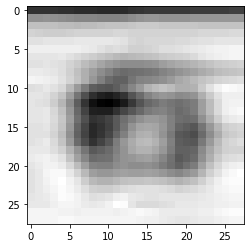

In [50]:
plt.imshow(x_test[4],cmap='gray')

In [51]:
y_test[3]

0

In [52]:
x_train = x_train.reshape(len(x_train),1,28,28)
x_test = x_test.reshape(len(x_test),1,28,28)
x_train = x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

(73257, 1, 28, 28)
(26032, 1, 28, 28)


In [53]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


In [54]:
train_dataset = MyDataset(x_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

In [55]:
test_loader = DataLoader(
    test_dataset,
    batch_size=26032,
    shuffle=False,
)

In [56]:
for image, labels in test_loader:
  pred_y = torch.max(model(image)[0], 1)[1].data.squeeze().numpy()
  accuracy = float((pred_y == labels.data.numpy()).astype(int).sum()) / float(labels.size(0))
print('The test set one-accuracy is:', accuracy)

The test set one-accuracy is: 0.30589274738783034


In [57]:
for image, labels in test_loader2:
  pred_y = torch.max(model(image)[0], 1)[1].data.squeeze().numpy()

In [58]:
file = open("/content/drive/MyDrive/cf/test_labels.txt", "r")
stringList = file.readlines()
extra_data = []
for i in range(len(stringList)):
  extra_data.append(len(stringList[i])-1)

In [59]:
print('The test set true-accuracy is:',get_accuracy(pred_y,y_test,extra_data))

The test set true-accuracy is: 0.14018977655341291


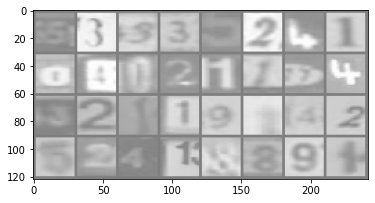

GroundTruth:  tensor(5) tensor(3) tensor(3) tensor(3) tensor(5) tensor(2) tensor(4) tensor(1) tensor(0) tensor(4) tensor(0) tensor(2) tensor(1) tensor(1) tensor(7) tensor(4) tensor(3) tensor(2) tensor(1) tensor(1) tensor(9) tensor(1) tensor(4) tensor(2) tensor(5) tensor(2) tensor(4) tensor(1) tensor(8) tensor(8) tensor(9) tensor(1)


In [60]:
images, labels = test_dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(32)))

In [61]:
test_output, last_layer = model(images)
pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()

print('Predicted: ', ' '.join('%5s' % pred_y[j]
                              for j in range(32)))

Predicted:      5     3     5     3     5     5     6     1     4     8     4     2     1     6     0     4     2     3     1     8     1     1     8     5     5     0     6     8     1     5     3     1
